In [2]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_runtime import SamplerV2


In [3]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

# To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
backend = AerSimulator()
backend

AerSimulator('aer_simulator')

In [4]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

hamiltonian = SparsePauliOp.from_list(
        [
        ('IIII', -0.09706627+0.j), ('ZIII',  0.17141283+0.j), ('IZII',  0.17141283+0.j),
        ('IIZI', -0.22343154+0.j), ('IIIZ', -0.22343154+0.j), ('ZZII',  0.16868898+0.j),
        ('ZIZI',  0.12062523+0.j), ('ZIIZ',  0.16592785+0.j), ('IZZI',  0.16592785+0.j),
        ('IZIZ',  0.12062523+0.j), ('IIZZ',  0.17441288+0.j),
        ('XXYY', -0.04530262+0.j),
        ('XYYX',  0.04530262+0.j),
        ('YXXY',  0.04530262+0.j),
        ('YYXX', -0.04530262+0.j)
    ]
)


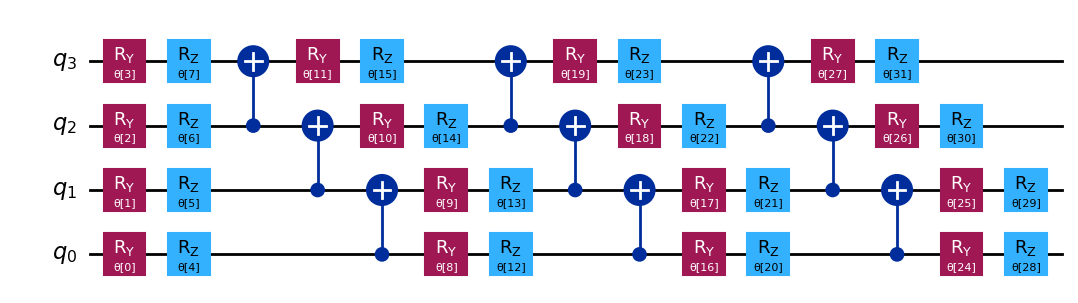

In [5]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [6]:
num_params = ansatz.num_parameters
num_params

32

In [7]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

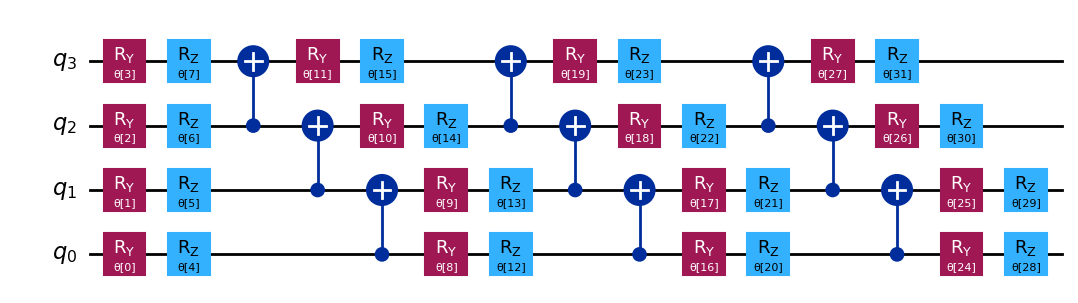

In [8]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [9]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

#### Cost Function

In [18]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def get_probability_distribution(counts, NUM_SHOTS):

    # All possible 4-qubit measurement outcomes
    all_possible_outcomes = ['0000', '0001', '0010', '0011',
                             '0100', '0101', '0110', '0111',
                             '1000', '1001', '1010', '1011',
                             '1100', '1101', '1110', '1111']
    
    # Ensure all possible outcomes are in counts
    for k in all_possible_outcomes:
        if k not in counts.keys():
            counts[k] = 0
            
    # Sort counts by outcome
    sorted_counts = sorted(counts.items())
    
    # Calculate the probability distribution
    output_distr = [v[1] / NUM_SHOTS for v in sorted_counts]
    
    return output_distr

def cost_func(params, ansatz, hamiltonian):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz params
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    # pub = (ansatz, [hamiltonian], [params])
    # result = estimator.run(pubs=[pub]).result()
    # energy = result[0].data.evs[0]


    # hamiltonian = SparsePauliOp.from_list(
    # [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)])

    shots = 10000
    sampler = SamplerV2(backend=AerSimulator())

    # Initialize the total expectation value
    energy = 0

    ## CLIQUE 1

    # clique_1 = SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'], [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j])
    # clique_1_pauli = ['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ']
    # clique_1_coeffs = [-0.09706627+0.j,  0.17141283+0.j,  0.17141283+0.j, -0.22343154+0.j, -0.22343154+0.j,  0.16868898+0.j,  0.12062523+0.j,  0.16592785+0.j, 0.16592785+0.j,  0.12062523+0.j,  0.17441288+0.j]
    # eigen_vals_1 = [
    #     np.kron(np.kron(np.kron([1,1], [1,1]), [1,1]), [1,1]),
    #     np.kron(np.kron(np.kron([1,1], [1,1]), [1,1]), [1,-1]),
    #     np.kron(np.kron(np.kron([1,1], [1,1]), [1,-1]), [1,1]),
    #     np.kron(np.kron(np.kron([1,1], [1,-1]), [1,1]), [1,1]),
    #     np.kron(np.kron(np.kron([1,-1], [1,1]), [1,1]), [1,1]),
    #     np.kron(np.kron(np.kron([1,1], [1,1]), [1,-1]), [1,-1]),
    #     np.kron(np.kron(np.kron([1,1], [1,-1]), [1,1]), [1,-1]),
    #     np.kron(np.kron(np.kron([1,-1], [1,1]), [1,1]), [1,-1]),
    #     np.kron(np.kron(np.kron([1,1], [1,-1]), [1,-1]), [1,1]),
    #     np.kron(np.kron(np.kron([1,-1], [1,1]), [1,-1]), [1,1]),
    #     np.kron(np.kron(np.kron([1,-1], [1,-1]), [1,1]), [1,1])
    # ]
    
    # ansatz_1 = ansatz.copy()
    # ansatz_1.measure_all()

    # job_1 = sampler.run([(ansatz_1, params)], shots=shots)
    # counts_1 = job_1.result()[0].data.meas.get_counts()
    # prob_dist_1 = get_probability_distribution(counts_1, sum(counts_1.values()))

    # exp_vals_1 = [x * y * z for x, y, z in zip(eigen_vals_1, prob_dist_1, clique_1_coeffs)]
    # energy += np.sum(exp_vals_1)



    ## CLIQUE 2
    clique_2 = SparsePauliOp(['XXYY'], [-0.04530262+0.j])
    ansatz_2 = ansatz.copy()
    ansatz_2.sdg([0,1])
    ansatz_2.h([0,1,2,3]) 
    ansatz_2.measure_all()

    job_2 = sampler.run([(ansatz_2, params)], shots=shots)
    counts_2 = job_2.result()[0].data.meas.get_counts()
    prob_dist_2 = get_probability_distribution(counts_2, sum(counts_2.values()))

    eigen_vals_2 = np.kron(np.kron(np.kron([1,-1], [1,-1]), [1,-1]), [1,-1])
    exp_vals_2 = np.dot(eigen_vals_2, prob_dist_2)
    
    energy += exp_vals_2*clique_2.coeffs[0]


    ## CLIQUE 3
    # clique_3 = SparsePauliOp(['XYYX'], [0.04530262+0.j])
    # ansatz_3 = ansatz.copy()
    # ansatz_3.sdg([1,2])
    # ansatz_3.h([0,1,2,3]) 
    # ansatz_3.measure_all()

    # job_3 = sampler.run([(ansatz_3, params)], shots=shots)
    # counts_3 = job_3.result()[0].data.meas.get_counts()
    # prob_dist_3 = get_probability_distribution(counts_3, sum(counts_3.values()))
    
    # eigen_vals_3 = np.kron(np.kron(np.kron([1,-1], [1,-1]), [1,-1]), [1,-1])
    # exp_vals_3 = np.dot(eigen_vals_3, prob_dist_3)
    # energy += exp_vals_3*clique_3.coeffs[0]


    ## CLIQUE 4
    # clique_4 = SparsePauliOp(['YXXY'], [0.04530262+0.j])
    # ansatz_4 = ansatz.copy()
    # ansatz_4.sdg([0,3])
    # ansatz_4.h([0,1,2,3]) 
    # ansatz_4.measure_all()

    # job_4 = sampler.run([(ansatz_4, params)], shots=shots)
    # counts_4 = job_4.result()[0].data.meas.get_counts()
    # prob_dist_4 = get_probability_distribution(counts_4, sum(counts_4.values()))
    
    # eigen_vals_4 = np.kron(np.kron(np.kron([1,-1], [1,-1]), [1,-1]), [1,-1])
    # exp_vals_4 = np.dot(eigen_vals_4, prob_dist_4)
    # energy += exp_vals_4*clique_4.coeffs[0]


    ## CLIQUE 5
    # clique_5 = SparsePauliOp(['YYXX'], [-0.04530262+0.j])
    # ansatz_5 = ansatz.copy()
    # ansatz_5.sdg([2,3])
    # ansatz_5.h([0,1,2,3]) 
    # ansatz_5.measure_all()

    # job_5 = sampler.run([(ansatz_5, params)], shots=shots)
    # counts_5 = job_5.result()[0].data.meas.get_counts()
    # prob_dist_5 = get_probability_distribution(counts_5, sum(counts_5.values()))
    
    # eigen_vals_5 = np.kron(np.kron(np.kron([1,-1], [1,-1]), [1,-1]), [1,-1])
    # exp_vals_5 = np.dot(eigen_vals_5, prob_dist_5)
    # energy += exp_vals_5*clique_5.coeffs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [19]:
np.random.seed(42)
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([2.35330497, 5.97351416, 4.59925358, 3.76148219, 0.98029403,
       0.98014248, 0.3649501 , 5.44234523, 3.77691701, 4.44895122,
       0.12933619, 6.09412333, 5.23039137, 1.33416598, 1.14243996,
       1.15236452, 1.91161039, 3.2971419 , 2.71399059, 1.82984665,
       3.84438512, 0.87646578, 1.83559896, 2.30191935, 2.86557222,
       4.93340606, 1.25458737, 3.23103027, 3.72225051, 0.29185655,
       3.81731689, 1.07143467])

In [20]:
with Session(backend=backend) as session:
    # estimator = Estimator(session=session)
    # estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa),
        method="cobyla",
    )

Iters. done: 1 [Current cost: (-0.024653685804+0j)]
Iters. done: 2 [Current cost: (-0.022850641528000003+0j)]
Iters. done: 3 [Current cost: (-0.020513026336000002+0j)]
Iters. done: 4 [Current cost: (-0.025441951392+0j)]
Iters. done: 5 [Current cost: (-0.016127732720000003+0j)]
Iters. done: 6 [Current cost: (-0.017178753504+0j)]
Iters. done: 7 [Current cost: (-0.025378527724000004+0j)]
Iters. done: 8 [Current cost: (-0.020984173584000003+0j)]
Iters. done: 9 [Current cost: (-0.018012321712+0j)]
Iters. done: 10 [Current cost: (-0.010057181640000001+0j)]
Iters. done: 11 [Current cost: (-0.016182095864+0j)]
Iters. done: 12 [Current cost: (-0.01916300826+0j)]
Iters. done: 13 [Current cost: (-0.011117262948+0j)]
Iters. done: 14 [Current cost: (-0.024046630696000004+0j)]
Iters. done: 15 [Current cost: (-0.02677384842+0j)]
Iters. done: 16 [Current cost: (-0.020349936904000002+0j)]
Iters. done: 17 [Current cost: (-0.021663712884+0j)]
Iters. done: 18 [Current cost: (-0.010510207839999999+0j)]
Ite

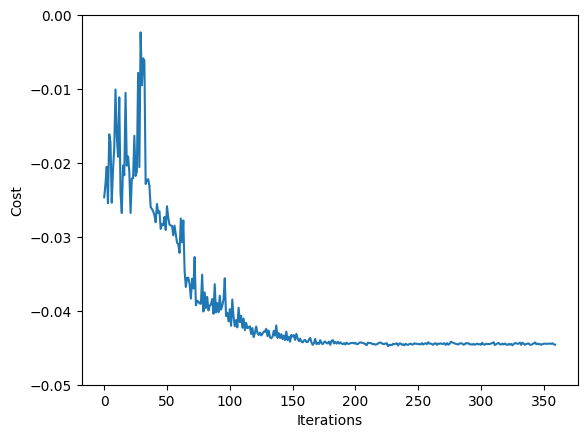

In [22]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.set_ylim(-0.05,0)
plt.draw()